# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pickle
from tqdm import tqdm
import os
from collections import Counter

# ============================== loading libraries ===========================================

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer

from prettytable import PrettyTable

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import itertools
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


##  Data Import and Preprocessing

**Load preprocessed 'final' data for linear kernel**

In [57]:
final = pickle.load(open('preprocessed_final_linear_kernel', 'rb'))

 *Checkpoint 2: Data is now sorted based on Time and preprocessed.*

In [58]:
# Create X and Y variable 
X = final['CleanedText'].values
y= final['Score'].values

In [59]:
type(X)

numpy.ndarray

In [60]:
type(y)

numpy.ndarray

In [61]:
# ss
from sklearn.model_selection import train_test_split

# Splitting into train and test in the ratio 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=False, random_state=507)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, shuffle=False, random_state=507)

In [62]:
print("Train Set:",X_train.shape, y_train.shape[0])
print("Test Set:",X_test.shape, y_test.shape[0])

Train Set: (61441,) 61441
Test Set: (26332,) 26332


*Checkpoint 3: Data has been partioned into train, cv and test*

##  Linear SVM

**Defining functions that we will be using throughout the notebook for BoW, TFIDF, AvgW2V, TFIDF-WW2V**


**Finding the hyper parameter alpha (i.e. 1/C) using RandomSearchCV with cv = 5**

In [63]:
def get_error_plot(X_train,penalty_l):
    
    """
    This funtion takes in the training data and runs CV with the penalty provided
    It returns the error plot
    """
    alpha = [10**-4, 10**-3,10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]
    
    params_dict = {
                "alpha": [10**-4, 10**-3,10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]
                
               }
    gs_obj = GridSearchCV(SGDClassifier(loss='hinge',penalty = penalty_l), param_grid = params_dict, scoring = 'roc_auc', cv=5)
    
    gs_obj.fit(X_train, y_train)


    train_scores_mean= gs_obj.cv_results_['mean_train_score']
    train_scores_std= gs_obj.cv_results_['std_train_score']
    test_scores_mean = gs_obj.cv_results_['mean_test_score'] 
    test_scores_std= gs_obj.cv_results_['std_test_score']
    
    # draws the error plot

    plt.plot(alpha, train_scores_mean, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    #plt.gca().fill_between(alpha,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

    plt.plot(alpha, test_scores_mean, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039 
    #plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel("log(alpha)- hyperparamter")
    plt.xscale('log')
    plt.ylabel("AUC")
    plt.title("ERROR PLOT")
    plt.show()

In [64]:
def get_best_hyperparameter_alpha(vectorizer, X_train, X_test, y_train, y_test):
  
    """
    This funtion takes in the vectorizer,  and performs SGDClassifier hyperparameter tuning using GridSearchCV with 5 fold cv 
    Returns the value of hyperparameter alpha and draws the error plot for various values of alpha
  
    Usage: get_best_hyperparameter_C(vectorizer, X_train, X_test, y_train, y_test, penalty)
    """
      
    params_dict = {
                "alpha": [10**-4, 10**-3,10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4], 
                "penalty": ['l1', 'l2']
               }
   
    # Using GridSearchCVSearchCV with 5 fold cv
    #gs_obj = GridSearchCV(LogisticRegression(penalty= penalty_l), tuned_parameters, scoring = 'roc_auc', cv=5)
    gs_obj = GridSearchCV(SGDClassifier(loss='hinge'), param_grid = params_dict, scoring = 'roc_auc', cv=5)

    gs_obj.fit(X_train, y_train)
  
  
    # Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
    means = gs_obj.cv_results_['mean_test_score']
    stds = gs_obj.cv_results_['std_test_score']


    t1 = PrettyTable()
    t1.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

    for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
        t1.add_row([round(mean, 3), round(std * 2,5), params])

    print(t1) 
  
    print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
    print("\nThe best score is:{}".format(gs_obj.best_score_))
    print("The best value of C is:{}".format(gs_obj.best_params_))

    # Returns the mean accuracy on the given test data and labels.
    print("Mean Score: {}".format(gs_obj.score(X_test, y_test)))
    #print("penalty: {}".format(gs_obj.best_params_['penalty']))
    
    #draws error plot
    get_error_plot(X_train, gs_obj.best_params_['penalty'])

**train and test AUC**

In [65]:
def plot_auc_sgd(model, X_train, X_test):
    
    """
    This function will plot the AUC for the vectorized train and test data.
    Returns the plot and also the values of auc for train and test
    
    Usage: auc_train, auc_test = plot_auc(model, X_train, X_test)
    """
    clf_sigmoid = CalibratedClassifierCV(model, cv=5, method='sigmoid')
    clf_sigmoid.fit(X_train, y_train)
    prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_sigmoid.predict_proba(X_train)[:, 1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_sigmoid.predict_proba(X_test)[:, 1])

    plt.plot([0,1],[0,1],'k--')
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("ROC Curve")
    plt.show()
    
    print("train AUC: {}".format(auc(train_fpr, train_tpr)))
    print("test AUC: {}".format(auc(test_fpr, test_tpr)))
    
    
    return auc(train_fpr, train_tpr), auc(test_fpr, test_tpr)
    

**important features**

In [66]:
# https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
  
    """
     Takes in the vectorizer, classifier (model) and the number of important features to return
  
     Usage: most_informative_feature_for_binary_classification(vectorizer, classifier, n=10)
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class_0 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class_1 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    t1 = PrettyTable()
    t1.field_names = ['Class', 'Coefficient (Importance)', 'Feature Name']
    
    for coef, feat in topn_class_0:
        t1.add_row([class_labels[0], abs(coef), feat])

    print(t1)
    
    print("*"*52)
    
    t2 = PrettyTable()
    t2.field_names = ['Class', 'Coefficient (Importance)', 'Feature Name']
 
    for coef, feat in reversed(topn_class_1):
        t2.add_row([class_labels[1], abs(coef), feat])
      
      
    print(t2)  

    #for coef, feat in topn_class1:
        #if coef < 0:
        #print(class_labels[0], abs(coef), feat)

    #print("*"*30)

    #for coef, feat in reversed(topn_class2):
        #if coef > 0:
     #   print(class_labels[1], abs(coef), feat)

**print confustion matrix**

In [67]:
def print_confusion_matrix(model, X_train, X_test):
    """
    Takes in the model, X_train, X_test and prints the confusion matrix
    Usage: print_confusion_matrix(model, X_train, X_test)
    """
    print("*****Train confusion matrix*****")
    print(confusion_matrix(y_train, model.predict(X_train)))
    print("\n*****Test confusion matrix*****")
    print(confusion_matrix(y_test, model.predict(X_test)))

**heat map of confusion matrix**

In [68]:
# Code modified from sklearn tutorial: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

# Heat map of confusion matrix

def plot_confusion_matrix_heatmap(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
     #   cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     #   print("Normalized confusion matrix")
    #else:
      #  print('Confusion matrix')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# [4.1] BAG OF WORDS

In [69]:
# ss
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer= CountVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
bow_vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = bow_vectorizer.transform(X_train)
#X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = bow_vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
#print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(61441, 10000) (61441,)
(26332, 10000) (26332,)


In [70]:
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of cut text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words: ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text BOW vectorizer  (61441, 10000)
the number of unique words:  10000


**Standardize the data**

In [71]:
# We will set the attribute with_mean = False, as StandardScaler does not work on sparse matrix
# when attempted on sparse matrices, because centering them entails building a dense matrix which in common use cases
# is likely to be too large to fit in memory.  ---> sklearn documentation

from sklearn.preprocessing import StandardScaler
X_train_bow=StandardScaler(with_mean=False).fit_transform(X_train_bow)
X_test_bow=StandardScaler(with_mean=False).fit_transform(X_test_bow)

print(X_train_bow.shape, y_train.shape) 

print(X_test_bow.shape, y_test.shape) 

C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(61441, 10000) (61441,)
(26332, 10000) (26332,)


### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

+---------------+--------------+------------------------------------+
| Mean CV Score | Std CV Score |               Param                |
+---------------+--------------+------------------------------------+
|     0.888     |   0.02585    | {'alpha': 0.0001, 'penalty': 'l1'} |
|     0.899     |   0.02626    | {'alpha': 0.0001, 'penalty': 'l2'} |
|     0.845     |   0.03581    | {'alpha': 0.001, 'penalty': 'l1'}  |
|     0.904     |   0.01819    | {'alpha': 0.001, 'penalty': 'l2'}  |
|     0.719     |   0.03024    |  {'alpha': 0.01, 'penalty': 'l1'}  |
|     0.912     |   0.01366    |  {'alpha': 0.01, 'penalty': 'l2'}  |
|     0.618     |    0.0509    |  {'alpha': 0.1, 'penalty': 'l1'}   |
|     0.928     |   0.01927    |  {'alpha': 0.1, 'penalty': 'l2'}   |
|      0.5      |    0.0184    |   {'alpha': 1, 'penalty': 'l1'}    |
|     0.912     |   0.02427    |   {'alpha': 1, 'penalty': 'l2'}    |
|      0.5      |   0.00111    |   {'alpha': 10, 'penalty': 'l1'}   |
|     0.698     |   

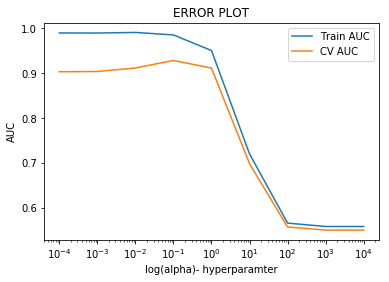

In [72]:
get_best_hyperparameter_alpha(bow_vectorizer, X_train_bow, X_test_bow, y_train, y_test)

In [98]:
model_bow_sgd = SGDClassifier(alpha= 0.1 ,penalty = 'l2')
model_bow_sgd.fit(X_train_bow,y_train)
y_pred = model_bow_sgd.predict(X_test_bow)

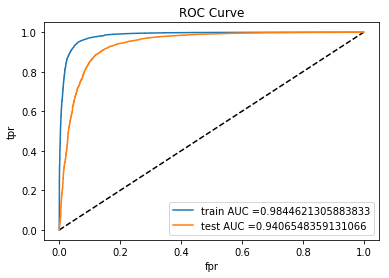

train AUC: 0.9844621305883833
test AUC: 0.9406548359131066


In [99]:
auc_train_bow_sgd, auc_test_bow_sgd = plot_auc_sgd(model_bow_sgd, X_train_bow, X_test_bow)

https://answers.dataiku.com/2711/probability-calibration-in-dataiku

**Most important features for BoW**

In [100]:
most_informative_feature_for_binary_classification(bow_vectorizer, model_bow_sgd)

+-------+--------------------------+---------------+
| Class | Coefficient (Importance) |  Feature Name |
+-------+--------------------------+---------------+
|   0   |   0.09635004651467102    |  disappointed |
|   0   |    0.0802213700099049    |     worst     |
|   0   |   0.07401661444290543    |   not worth   |
|   0   |   0.07161304594053323    |    not buy    |
|   0   |   0.07158800461883856    |    terrible   |
|   0   |   0.07084121621217061    |    not good   |
|   0   |   0.06940553529083396    | not recommend |
|   0   |   0.06360239115214682    | disappointing |
|   0   |   0.06306238333750386    |     awful     |
|   0   |   0.06061576273183535    |   two stars   |
+-------+--------------------------+---------------+
****************************************************
+-------+--------------------------+--------------+
| Class | Coefficient (Importance) | Feature Name |
+-------+--------------------------+--------------+
|   1   |    0.1569419250296165    |    great    

In [101]:
# Confusion Matrix
print_confusion_matrix(model_bow_sgd, X_train_bow, X_test_bow)

*****Train confusion matrix*****
[[ 7889  1735]
 [  638 51179]]

*****Test confusion matrix*****
[[ 3210  1347]
 [  636 21139]]


<Figure size 432x288 with 0 Axes>

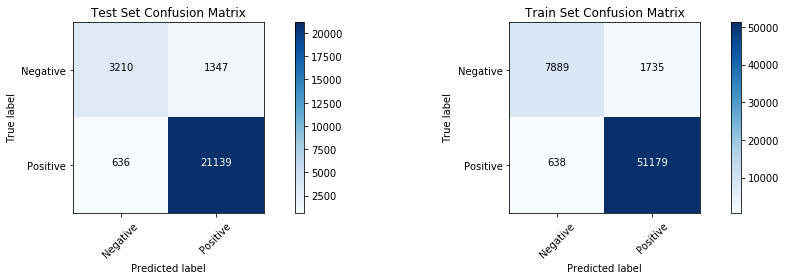

In [102]:
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_bow_sgd.predict(X_test_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_bow_sgd.predict(X_train_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');


**Observation**
1. For the BoW vectorizer, we calculated alpha = 0.1 using GridSearchCV with cv = 5 and with penalty l2. 
2. We got train AUC: 0.9844621305883833 and test AUC: 0.9406548359131066 
3. Using the confusion matrix, we can say that our model correctly predicted 21139 positive reviews and 3210 negative reviews.
4. The model incorrectly classified 636 negative reviews and 1347 positive reviews.

**Feature Engineering** Let us perform FE to see if we can further improve the model. Here, we will append length of reviews as another feature.

In [73]:
def get_text_length(x):
    """
     This function takes in a array and returns the length of the elements in the array.
    """
    return np.array([len(t) for t in x]).reshape(-1, 1)

In [74]:
rev_len_X_train = get_text_length(X_train)
rev_len_X_test = get_text_length(X_test)

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer_fe = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
bow_vectorizer_fe.fit(X_train) # fit has to happen only on train data

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=10,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [76]:
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = bow_vectorizer_fe.transform(X_train)
X_test_bow = bow_vectorizer_fe.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(61441, 10000) (61441,)
(26332, 10000) (26332,)


**Standardize the data**

In [77]:
# We will set the attribute with_mean = False, as StandardScaler does not work on sparse matrix
# when attempted on sparse matrices, because centering them entails building a dense matrix which in common use cases
# is likely to be too large to fit in memory.  ---> sklearn documentation

from sklearn.preprocessing import StandardScaler
X_train_bow=StandardScaler(with_mean=False).fit_transform(X_train_bow)
X_test_bow=StandardScaler(with_mean=False).fit_transform(X_test_bow)

print(X_train_bow.shape, y_train.shape) 

print(X_test_bow.shape, y_test.shape) 

C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(61441, 10000) (61441,)
(26332, 10000) (26332,)


In [78]:
type(rev_len_X_train)


numpy.ndarray

In [79]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [80]:
from scipy.sparse import hstack
# Here we append the sparse matrix and the dense array that contains the length of the text passed to it
X_train_bow_fe = hstack((X_train_bow, np.array(rev_len_X_train)))
X_test_bow_fe = hstack((X_test_bow, np.array(rev_len_X_test)))

+---------------+--------------+------------------------------------+
| Mean CV Score | Std CV Score |               Param                |
+---------------+--------------+------------------------------------+
|     0.908     |    0.0301    | {'alpha': 0.0001, 'penalty': 'l1'} |
|     0.867     |   0.16914    | {'alpha': 0.0001, 'penalty': 'l2'} |
|     0.859     |   0.04961    | {'alpha': 0.001, 'penalty': 'l1'}  |
|      0.92     |   0.07292    | {'alpha': 0.001, 'penalty': 'l2'}  |
|     0.738     |   0.05858    |  {'alpha': 0.01, 'penalty': 'l1'}  |
|     0.937     |   0.01175    |  {'alpha': 0.01, 'penalty': 'l2'}  |
|     0.514     |   0.03485    |  {'alpha': 0.1, 'penalty': 'l1'}   |
|      0.93     |   0.03104    |  {'alpha': 0.1, 'penalty': 'l2'}   |
|     0.443     |   0.02479    |   {'alpha': 1, 'penalty': 'l1'}    |
|     0.901     |   0.04563    |   {'alpha': 1, 'penalty': 'l2'}    |
|     0.442     |   0.02502    |   {'alpha': 10, 'penalty': 'l1'}   |
|     0.557     |   

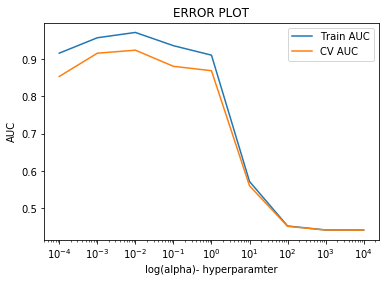

In [81]:
# Get the best hyperparameter using GridSearchCV with penalty l1 and cv = 5
get_best_hyperparameter_alpha(bow_vectorizer_fe, X_train_bow_fe, X_test_bow_fe, y_train, y_test)

In [103]:
# Fitting the BoW vectorizer on LogisticRegression Model with penalty l1 and C = 0.01 
model_bow_fe_sgd = SGDClassifier(alpha = 0.01 ,penalty = 'l2')
model_bow_fe_sgd.fit(X_train_bow_fe,y_train)
y_pred = model_bow_fe_sgd.predict(X_test_bow_fe)

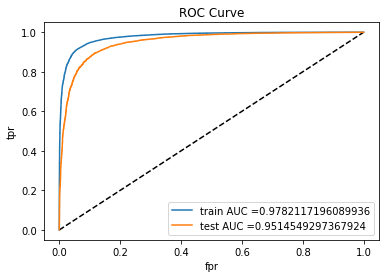

train AUC: 0.9782117196089936
test AUC: 0.9514549297367924


In [104]:
# AUC-ROC plot
auc_train_bow_fe_sgd, auc_test_bow_fe_sgd = plot_auc_sgd(model_bow_fe_sgd, X_train_bow_fe, X_test_bow_fe)

In [105]:
# Confusion Matrix
print_confusion_matrix(model_bow_fe_sgd, X_train_bow_fe, X_test_bow_fe)

*****Train confusion matrix*****
[[ 7270  2354]
 [  783 51034]]

*****Test confusion matrix*****
[[ 2970  1587]
 [  521 21254]]


<Figure size 432x288 with 0 Axes>

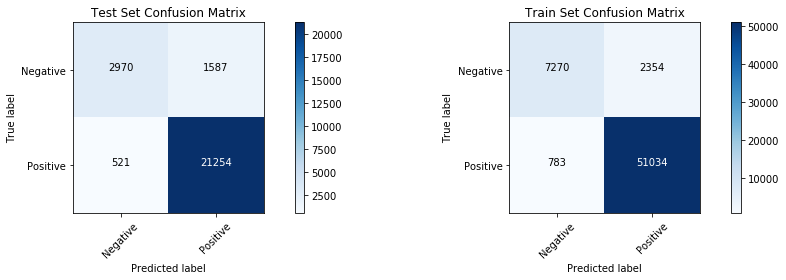

In [106]:
# Confustion Matrix heatmap
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_bow_fe_sgd.predict(X_test_bow_fe))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_bow_fe_sgd.predict(X_train_bow_fe))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the BoW vectorizer with Feature Engineering, we calculated C = 0.01 using GridSearchCV with cv = 5 and with penalty l2. 
2. We got train AUC: 0.9782117196089936 and test AUC: 0.9514549297367924
3. Using the confusion matrix, we can say that our model correctly predicted 21245 positive reviews and 2970 negative reviews.
4. The model incorrectly classified 521 negative reviews and 1587 positive reviews.
5. **Doing Feature Engineering has made the model slightly perform better than the model without feature engineering.**


## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
#count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
#final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
#print("the type of count vectorizer ",type(final_bigram_counts))
#print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [82]:
# ss
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
#X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
#print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(61441, 36173) (61441,)
(26332, 36173) (26332,)


In [83]:
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of cut text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words: ", X_train_tfidf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text TFIDF vectorizer  (61441, 36173)
the number of unique words:  36173


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

+---------------+--------------+------------------------------------+
| Mean CV Score | Std CV Score |               Param                |
+---------------+--------------+------------------------------------+
|      0.93     |   0.01365    | {'alpha': 0.0001, 'penalty': 'l1'} |
|     0.955     |   0.01329    | {'alpha': 0.0001, 'penalty': 'l2'} |
|     0.678     |    0.0804    | {'alpha': 0.001, 'penalty': 'l1'}  |
|     0.948     |   0.01552    | {'alpha': 0.001, 'penalty': 'l2'}  |
|      0.5      |     0.0      |  {'alpha': 0.01, 'penalty': 'l1'}  |
|     0.948     |   0.01529    |  {'alpha': 0.01, 'penalty': 'l2'}  |
|      0.5      |     0.0      |  {'alpha': 0.1, 'penalty': 'l1'}   |
|     0.589     |   0.02017    |  {'alpha': 0.1, 'penalty': 'l2'}   |
|      0.5      |     0.0      |   {'alpha': 1, 'penalty': 'l1'}    |
|     0.589     |   0.02015    |   {'alpha': 1, 'penalty': 'l2'}    |
|      0.5      |     0.0      |   {'alpha': 10, 'penalty': 'l1'}   |
|     0.589     |   

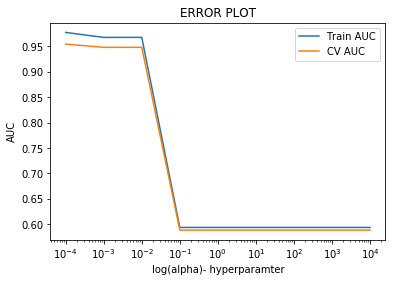

In [84]:
# Get the best hyperparameter using GridSearchCV with penalty l1 and cv = 5
get_best_hyperparameter_alpha(tf_idf_vect, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [107]:
# Fitting the model with the best hyperparameter
model_tfidf_sgd = SGDClassifier(alpha= 0.0001 ,penalty = 'l2')
model_tfidf_sgd.fit(X_train_tfidf,y_train)
y_pred = model_tfidf_sgd.predict(X_test_tfidf)

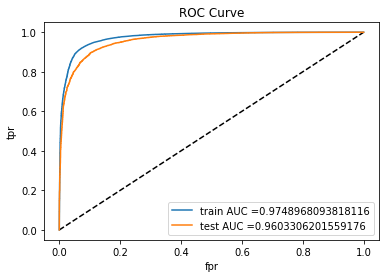

train AUC: 0.9748968093818116
test AUC: 0.9603306201559176


In [108]:
# AUC- ROC plot
auc_train_tfidf_sgd, auc_test_tfidf_sgd = plot_auc_sgd(model_tfidf_sgd, X_train_tfidf, X_test_tfidf)

In [109]:
# Confusion Matrix
print_confusion_matrix(model_tfidf_sgd, X_train_tfidf, X_test_tfidf)

*****Train confusion matrix*****
[[ 5022  4602]
 [  230 51587]]

*****Test confusion matrix*****
[[ 2204  2353]
 [  159 21616]]


<Figure size 432x288 with 0 Axes>

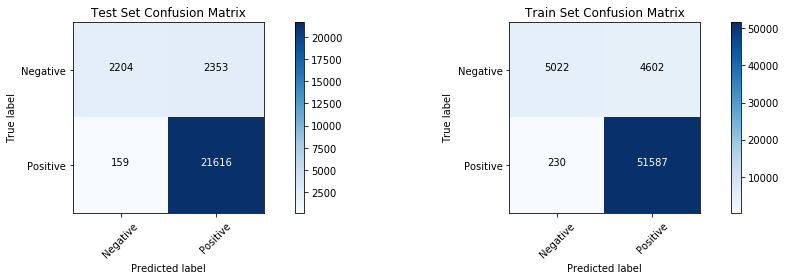

In [110]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidf_sgd.predict(X_test_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidf_sgd.predict(X_train_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the TFIDF vectorizer, we calculated C = 0.0001 using GridSearchCV with cv = 5 and with penalty l2. 
2. We got train AUC: 0.9748968093818116 and test AUC: 0.9603306201559176
3. Using the confusion matrix, we can say that our model correctly predicted 21616 positive reviews and 2204 negative reviews.
4. The model incorrectly classified 159 negative reviews and 2353 positive reviews.

## [4.4] Word2Vec

In [85]:
# Train your own Word2Vec model using your own text corpus 
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [86]:
print(list_of_sentance_train[0])

['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'flies', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'flies', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching']


In [87]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.821457028388977), ('terrific', 0.8163110613822937), ('fantastic', 0.8123440146446228), ('excellent', 0.8065283894538879), ('awesome', 0.8021259903907776), ('wonderful', 0.797581136226654), ('perfect', 0.7288220524787903), ('nice', 0.7148672938346863), ('fabulous', 0.7089940309524536), ('decent', 0.695073127746582)]
[('greatest', 0.7920302748680115), ('best', 0.7550718784332275), ('nastiest', 0.7323176860809326), ('tastiest', 0.7221068143844604), ('closest', 0.6759981513023376), ('coolest', 0.662483274936676), ('disgusting', 0.6464158296585083), ('humble', 0.6225912570953369), ('softest', 0.5897253751754761), ('smoothest', 0.5827312469482422)]


In [88]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14799
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


**Converting train text data**

In [89]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61441/61441 [01:52<00:00, 618.29it/s]


(61441, 50)
[ 0.5   0.28  0.01  0.78  0.19 -0.33 -0.03 -0.04 -0.18 -0.08  0.39  0.13
  0.2   0.1  -0.27 -0.62 -0.13 -0.44  0.11 -0.07 -0.22  0.14  0.17  0.27
  0.08  0.21  0.48  0.5   0.5   0.04  0.06 -0.39  0.38 -0.19 -0.28 -0.05
  1.   -0.05 -0.44 -0.11 -0.13 -0.32  0.11 -0.2   0.22  0.   -0.    0.42
  0.13 -0.12]


**Converting test text data**

In [90]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [91]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)

print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26332/26332 [00:44<00:00, 595.22it/s]


(26332, 50)
[-0.2   0.15  0.1  -0.8  -0.12  1.12 -0.45 -0.67 -0.05 -0.19  0.26 -0.81
 -0.47  1.24  0.33 -0.78  0.16  0.49  0.04 -0.53  0.3  -0.21  0.2   0.67
 -0.06 -0.68  0.22  0.41 -0.04 -0.09 -0.73  0.46  0.09 -0.74 -0.39 -1.04
  0.48  0.09 -0.01  0.49 -0.01 -0.5  -0.3  -0.27 -0.16  1.19 -0.3   0.36
  0.01  0.56]


hyperparameter tuning with cv = 5 using gridsearch

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [92]:
params_dict = {
                "alpha": [10**-4, 10**-3,10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4], 
                "penalty": ['l1', 'l2']
               }
   
# Using GridSearchCVSearchCV with 5 fold cv
gs_obj = GridSearchCV(SGDClassifier(loss='hinge'), param_grid = params_dict, scoring = 'roc_auc', cv=5)

gs_obj.fit(sent_vectors_train, y_train)
  
# Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
means = gs_obj.cv_results_['mean_test_score']
stds = gs_obj.cv_results_['std_test_score']


t1 = PrettyTable()
t1.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
    t1.add_row([round(mean, 3), round(std * 2,5), params])

print(t1) 

print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
print("\nThe best score is:{}".format(gs_obj.best_score_))
print("The best value of C is:{}".format(gs_obj.best_params_))

# Returns the mean accuracy on the given test data and labels.
print("Mean Score: {}".format(gs_obj.score(sent_vectors_test, y_test)))
   
del t1    

+---------------+--------------+------------------------------------+
| Mean CV Score | Std CV Score |               Param                |
+---------------+--------------+------------------------------------+
|     0.894     |   0.01043    | {'alpha': 0.0001, 'penalty': 'l1'} |
|      0.89     |   0.01894    | {'alpha': 0.0001, 'penalty': 'l2'} |
|      0.9      |   0.01401    | {'alpha': 0.001, 'penalty': 'l1'}  |
|      0.9      |   0.01779    | {'alpha': 0.001, 'penalty': 'l2'}  |
|      0.86     |    0.0229    |  {'alpha': 0.01, 'penalty': 'l1'}  |
|     0.901     |   0.01561    |  {'alpha': 0.01, 'penalty': 'l2'}  |
|      0.5      |     0.0      |  {'alpha': 0.1, 'penalty': 'l1'}   |
|      0.9      |   0.01582    |  {'alpha': 0.1, 'penalty': 'l2'}   |
|      0.5      |     0.0      |   {'alpha': 1, 'penalty': 'l1'}    |
|     0.898     |   0.02486    |   {'alpha': 1, 'penalty': 'l2'}    |
|      0.5      |     0.0      |   {'alpha': 10, 'penalty': 'l1'}   |
|     0.798     |   

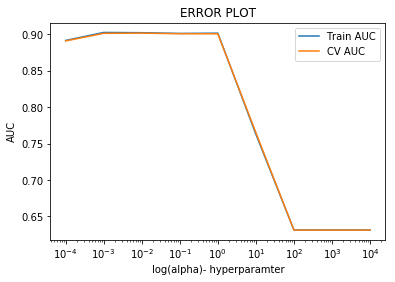

In [93]:
alpha = [10**-4, 10**-3,10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]
    
params_dict = {
                "alpha": [10**-4, 10**-3,10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]
                
               }
gs_obj = GridSearchCV(SGDClassifier(loss='hinge',penalty = 'l2'), param_grid = params_dict, scoring = 'roc_auc', cv=5)
    
gs_obj.fit(sent_vectors_train, y_train)


train_scores_mean= gs_obj.cv_results_['mean_train_score']
train_scores_std= gs_obj.cv_results_['std_train_score']
test_scores_mean = gs_obj.cv_results_['mean_test_score'] 
test_scores_std= gs_obj.cv_results_['std_test_score']
    
# draws the error plot

plt.plot(alpha, train_scores_mean, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    #plt.gca().fill_between(alpha,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, test_scores_mean, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039 
    #plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(alpha)- hyperparamter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("ERROR PLOT")
plt.show()

In [115]:
# Fitting the model with the best hyperparameter
model_avgw2v_sgd = SGDClassifier(alpha= 0.01 ,penalty = 'l2')
model_avgw2v_sgd.fit(sent_vectors_train,y_train)
y_pred = model_avgw2v_sgd.predict(sent_vectors_test)

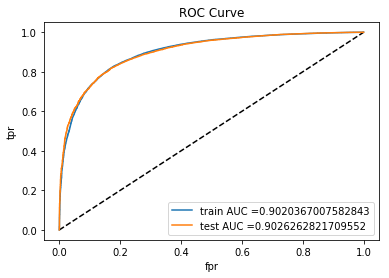

train AUC: 0.9020367007582843
test AUC: 0.9026262821709552


In [116]:
# AUC - ROC plot
auc_train_avgw2v_l1, auc_test_avgw2v_l1 = plot_auc_sgd(model_avgw2v_sgd, sent_vectors_train, sent_vectors_test)

In [117]:
# Confusion matrix
print_confusion_matrix(model_avgw2v_sgd, sent_vectors_train, sent_vectors_test)

*****Train confusion matrix*****
[[ 2592  7032]
 [  627 51190]]

*****Test confusion matrix*****
[[ 1252  3305]
 [  251 21524]]


<Figure size 432x288 with 0 Axes>

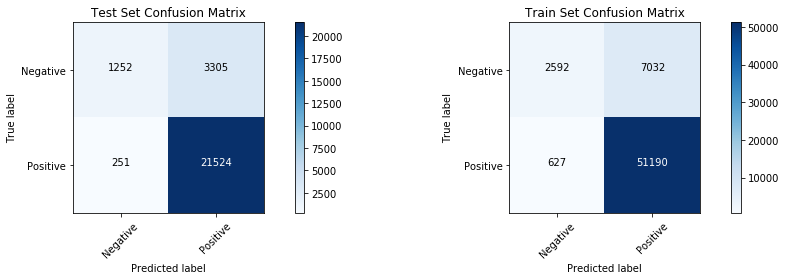

In [118]:
# Heatmap confusion matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_avgw2v_sgd.predict(sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_avgw2v_sgd.predict(sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the BoW vectorizer, we calculated C = 0.01 using GridSearchCV with cv = 5 and with penalty l2. 
2. We got train AUC: 0.902424731877006 and test AUC: 0.9015779662481638
3. Using the confusion matrix, we can say that our model correctly predicted 20987 positive reviews and 2146 negative reviews.
4. The model incorrectly classified 788 negative reviews and 2411 positive reviews.


#### [4.4.1.2] TFIDF weighted W2v

In [94]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
X_train_tf_idf_w2v = model.fit_transform(X_train)
X_test_tf_idf_w2v = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [95]:
# TF-IDF weighted Word2Vec for sentences in X_train
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61441/61441 [24:44<00:00, 32.20it/s]


In [96]:
# TF-IDF weighted Word2Vec for sentences in X_test
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26332/26332 [11:18<00:00, 58.06it/s]


### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

+---------------+--------------+------------------------------------+
| Mean CV Score | Std CV Score |               Param                |
+---------------+--------------+------------------------------------+
|     0.856     |    0.027     | {'alpha': 0.0001, 'penalty': 'l1'} |
|     0.858     |   0.02295    | {'alpha': 0.0001, 'penalty': 'l2'} |
|     0.877     |   0.01896    | {'alpha': 0.001, 'penalty': 'l1'}  |
|     0.876     |   0.02032    | {'alpha': 0.001, 'penalty': 'l2'}  |
|     0.819     |   0.04099    |  {'alpha': 0.01, 'penalty': 'l1'}  |
|     0.877     |   0.02028    |  {'alpha': 0.01, 'penalty': 'l2'}  |
|      0.5      |     0.0      |  {'alpha': 0.1, 'penalty': 'l1'}   |
|     0.876     |    0.0207    |  {'alpha': 0.1, 'penalty': 'l2'}   |
|      0.5      |     0.0      |   {'alpha': 1, 'penalty': 'l1'}    |
|     0.876     |   0.02009    |   {'alpha': 1, 'penalty': 'l2'}    |
|      0.5      |     0.0      |   {'alpha': 10, 'penalty': 'l1'}   |
|     0.756     |   

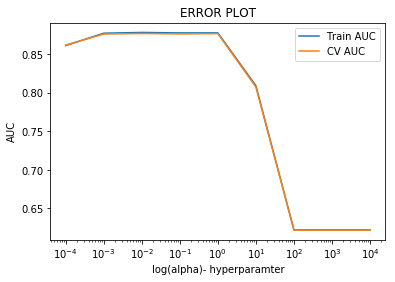

In [97]:
get_best_hyperparameter_alpha(model, tfidf_sent_vectors_train, tfidf_sent_vectors_test, y_train, y_test)

In [111]:
# Fitting the TFIDF - weighted W2V vectorizer on LogisticRegression Model 
model_tfidfw2v_sgd = SGDClassifier(alpha= 0.01 ,penalty = 'l2')
model_tfidfw2v_sgd.fit(tfidf_sent_vectors_train,y_train)
y_pred = model_tfidfw2v_sgd.predict(tfidf_sent_vectors_test)

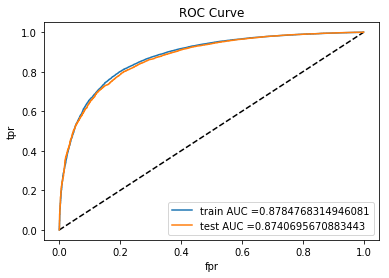

train AUC: 0.8784768314946081
test AUC: 0.8740695670883443


In [112]:
# AUC- ROC plot
auc_train_tfidfw2v_sgd, auc_test_tfidfw2v_sgd = plot_auc_sgd(model_tfidfw2v_sgd, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

In [113]:
# Confusion Matrix
print_confusion_matrix(model_tfidfw2v_sgd, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

*****Train confusion matrix*****
[[ 1240  8384]
 [  292 51525]]

*****Test confusion matrix*****
[[  620  3937]
 [  123 21652]]


<Figure size 432x288 with 0 Axes>

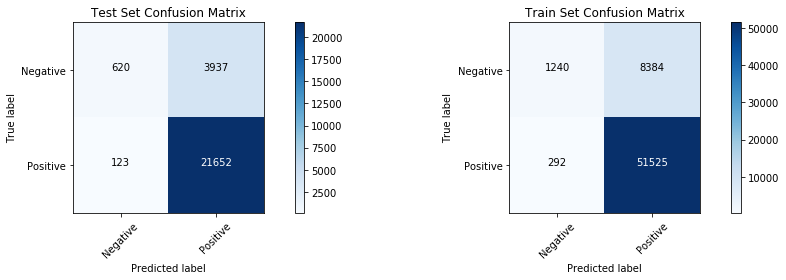

In [114]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidfw2v_sgd.predict(tfidf_sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidfw2v_sgd.predict(tfidf_sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the BoW vectorizer, we calculated C = 0.01 using GridSearchCV with cv = 5 and with penalty l2. 
2. We got train AUC: 0.8784768314946081 and test AUC: 0.8740695670883443
3. Using the confusion matrix, we can say that our model correctly predicted 21652 positive reviews and 620 negative reviews.
4. The model incorrectly classified 123 negative reviews and 3937 positive reviews.

In [121]:
#del final

#del X, y, X_train_tfidf, X_test, y_train, y_test, X_train_bow, X_test_bow,X_train_bow_fe, X_test_bow_fe
#del w2v_words, tfidf_feat, tfidf_sent_vectors_test, tfidf_sent_vectors_train, sent_vectors_test, sent_vectors_train, sent_vec

## RBF SVM

In [2]:
final = pickle.load(open('preprocessed_final_rbf_kernel', 'rb'))

In [3]:
def get_best_hyperparameter_alpha_rbf(vectorizer, X_train, X_test, y_train, y_test):
  
    """
    This funtion takes in the vectorizer,  and performs LogissticRegression hyperparameter tuning using GridSearchCV with 5 fold cv 
    Returns the value of hyperparameter C and draws the error plot for various values of C
  
    Usage: get_best_hyperparameter_C(vectorizer, X_train, X_test, y_train, y_test, penalty)
    """
    tuned_parameters = [{'C': [10**-4, 10**-3,10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]}]
    alpha = [10**-4, 10**-3,10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]  #k
    
    #tuned_parameters = [{'C': [10**-4, 10**-3,10**-2]}]
    #alpha = [10**-4, 10**-3,10**-2]

    # Using GridSearchCVSearchCV with 5 fold cv
    gs_obj = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, scoring = 'roc_auc', cv=3)

    gs_obj.fit(X_train, y_train)


    train_auc= gs_obj.cv_results_['mean_train_score']
    train_auc_std= gs_obj.cv_results_['std_train_score']
    cv_auc = gs_obj.cv_results_['mean_test_score'] 
    cv_auc_std= gs_obj.cv_results_['std_test_score']

  
    # draws the error plot
  
    plt.plot(alpha, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(alpha,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

    plt.plot(alpha, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039 
    plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel("log(C)- hyperparamter")
    plt.xscale('log')
    plt.ylabel("AUC")
    plt.title("ERROR PLOT")
    plt.show()
  
  
    # Results of the gs object
  
  
    # Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
    means = gs_obj.cv_results_['mean_test_score']
    stds = gs_obj.cv_results_['std_test_score']


    t1 = PrettyTable()
    t1.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

    for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
        t1.add_row([round(mean, 3), round(std * 2,5), params])

    print(t1) 
  
    print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
    print("\nThe best score is:{}".format(gs_obj.best_score_))
    print("The best value of C is:{}".format(gs_obj.best_params_))

    # Returns the mean accuracy on the given test data and labels.
    print("Mean Score: {}".format(gs_obj.score(X_test, y_test)))
    
    
    return gs_obj.best_params_
    

In [4]:
def plot_auc_rbf(model, X_train, X_test):
    
    """
    This function will plot the AUC for the vectorized train and test data.
    Returns the plot and also the values of auc for train and test
    
    Usage: auc_train, auc_test = plot_auc(model, X_train, X_test)
    """
    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

    plt.plot([0,1],[0,1],'k--')
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("ROC Curve")
    plt.show()
    
    print("train AUC: {}".format(auc(train_fpr, train_tpr)))
    print("test AUC: {}".format(auc(test_fpr, test_tpr)))
    
    
    return auc(train_fpr, train_tpr), auc(test_fpr, test_tpr)
    

**Print Confusion Matrix**

In [5]:
def print_confusion_matrix(model, X_train, X_test):
    """
    Takes in the model, X_train, X_test and prints the confusion matrix
    Usage: print_confusion_matrix(model, X_train, X_test)
    """
    print("*****Train confusion matrix*****")
    print(confusion_matrix(y_train, model.predict(X_train)))
    print("\n*****Test confusion matrix*****")
    print(confusion_matrix(y_test, model.predict(X_test)))

In [6]:
# Create X and Y variable 
X = final['CleanedText'].values
y= final['Score'].values

In [7]:
from sklearn.model_selection import train_test_split

# Splitting into train and test in the ratio 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=False, random_state=507)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, shuffle=False, random_state=507)

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

**Bag Of Words**

In [9]:
# ss
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer_rbf= CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
bow_vectorizer_rbf.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = bow_vectorizer_rbf.transform(X_train)
#X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = bow_vectorizer_rbf.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
#print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(26190, 500) (26190,)
(11225, 500) (11225,)


In [10]:
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of cut text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words: ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text BOW vectorizer  (26190, 500)
the number of unique words:  500


**Standardize the data**

In [11]:
# We will set the attribute with_mean = False, as StandardScaler does not work on sparse matrix
# when attempted on sparse matrices, because centering them entails building a dense matrix which in common use cases
# is likely to be too large to fit in memory.  ---> sklearn documentation

from sklearn.preprocessing import StandardScaler
X_train_bow=StandardScaler(with_mean=False).fit_transform(X_train_bow)
X_test_bow=StandardScaler(with_mean=False).fit_transform(X_test_bow)

print(X_train_bow.shape, y_train.shape) 

print(X_test_bow.shape, y_test.shape) 

C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(26190, 500) (26190,)
(11225, 500) (11225,)


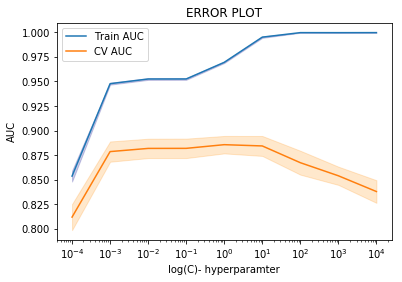

+---------------+--------------+---------------+
| Mean CV Score | Std CV Score |     Param     |
+---------------+--------------+---------------+
|     0.812     |   0.02647    | {'C': 0.0001} |
|     0.879     |   0.02059    |  {'C': 0.001} |
|     0.882     |   0.01969    |  {'C': 0.01}  |
|     0.882     |   0.01978    |   {'C': 0.1}  |
|     0.886     |   0.01775    |    {'C': 1}   |
|     0.884     |    0.0203    |   {'C': 10}   |
|     0.867     |   0.02432    |   {'C': 100}  |
|     0.854     |   0.01855    |  {'C': 1000}  |
|     0.838     |   0.02302    |  {'C': 10000} |
+---------------+--------------+---------------+

The best estimator:SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

The best score is:0.8855856974636146
The best value of C is:{'C': 1}
Mean Score: 0.9036181817268996


{'C': 1}

In [12]:
get_best_hyperparameter_alpha_rbf(bow_vectorizer_rbf, X_train_bow,X_test_bow, y_train, y_test)

In [31]:
#SVC(kernel='rbf')
model_bow_rbf = SVC(kernel='rbf', C= 1, probability=True)
model_bow_rbf.fit(X_train_bow,y_train)
y_pred = model_bow_rbf.predict(X_test_bow)

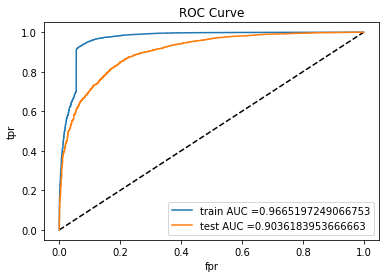

train AUC: 0.9665197249066753
test AUC: 0.9036183953666663


In [32]:
#train_auc, test_auc = plot_auc_rbf(bow_vectorizer_rbf, X_train_bow, X_test_bow)
auc_train_bow_rbf, auc_test_bow_rbf = plot_auc_rbf(model_bow_rbf, X_train_bow, X_test_bow)

In [33]:
print_confusion_matrix(model_bow_rbf, X_train_bow, X_test_bow)

*****Train confusion matrix*****
[[ 2709  1344]
 [  109 22028]]

*****Test confusion matrix*****
[[ 742 1296]
 [ 142 9045]]


<Figure size 432x288 with 0 Axes>

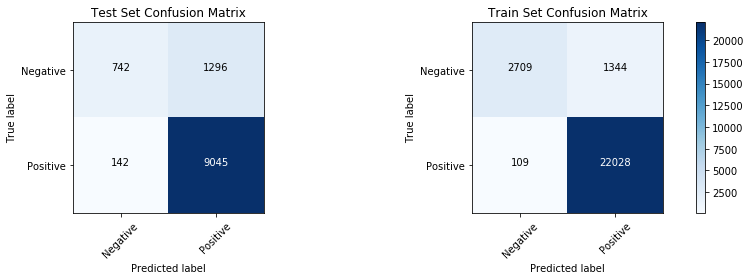

In [42]:
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_bow_rbf.predict(X_test_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_bow_rbf.predict(X_train_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');


**Observation**
1. For the BoW vectorizer, we used SVC classifier with RBF kernel and C = 1
2. We got train AUC: 0.9665197249066753 and test AUC: 0.9036183953666663
3. Using the confusion matrix, we can say that our model correctly predicted 9045 positive reviews and 742 negative reviews.
4. The model incorrectly classified 142 negative reviews and 1296 positive reviews.

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

**TF-IDF**


In [13]:
# ss
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
#X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
#print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(26190, 15875) (26190,)
(11225, 15875) (11225,)


In [14]:
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of cut text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words: ", X_train_tfidf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text TFIDF vectorizer  (26190, 15875)
the number of unique words:  15875


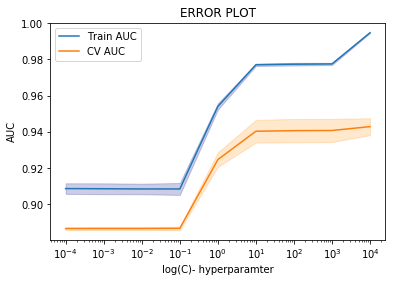

+---------------+--------------+---------------+
| Mean CV Score | Std CV Score |     Param     |
+---------------+--------------+---------------+
|     0.887     |   0.00168    | {'C': 0.0001} |
|     0.887     |   0.00175    |  {'C': 0.001} |
|     0.887     |   0.00171    |  {'C': 0.01}  |
|     0.887     |   0.00185    |   {'C': 0.1}  |
|     0.925     |   0.00794    |    {'C': 1}   |
|      0.94     |   0.01257    |   {'C': 10}   |
|     0.941     |   0.01291    |   {'C': 100}  |
|     0.941     |   0.01278    |  {'C': 1000}  |
|     0.943     |    0.0093    |  {'C': 10000} |
+---------------+--------------+---------------+

The best estimator:SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

The best score is:0.9428445170872043
The best value of C is:{'C': 10000}
Mean Score: 0.9583121251356479


{'C': 10000}

In [15]:
get_best_hyperparameter_alpha_rbf(tf_idf_vect, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [43]:
# Fitting the model with the best hyperparameter
model_tfidf_rbf = SVC(kernel='rbf', C= 10000, probability=True)
model_tfidf_rbf.fit(X_train_tfidf,y_train)
y_pred = model_tfidf_rbf.predict(X_test_tfidf)

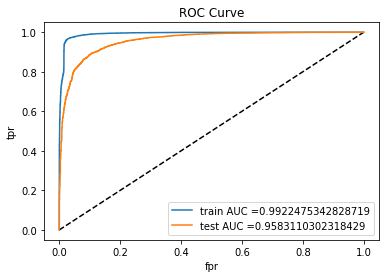

train AUC: 0.9922475342828719
test AUC: 0.9583110302318429


In [44]:
# AUC- ROC plot
auc_train_tfidf_rbf, auc_test_tfidf_rbf = plot_auc_rbf(model_tfidf_rbf, X_train_tfidf, X_test_tfidf)

In [45]:
# Confusion Matrix
print_confusion_matrix(model_tfidf_rbf, X_train_tfidf, X_test_tfidf)

*****Train confusion matrix*****
[[ 3425   628]
 [  129 22008]]

*****Test confusion matrix*****
[[1373  665]
 [ 220 8967]]


<Figure size 432x288 with 0 Axes>

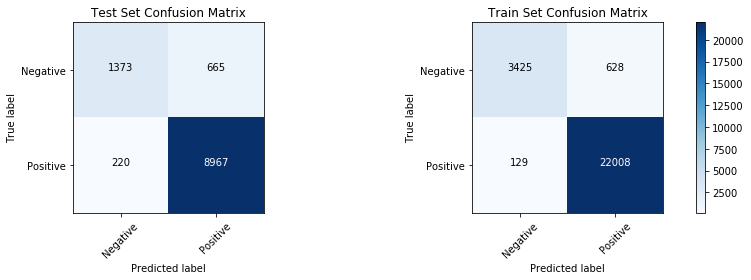

In [46]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidf_rbf.predict(X_test_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidf_rbf.predict(X_train_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the TF-IDF vectorizer, we used SVC classifier with RBF kernel and C = 10000
2. We got train AUC: 0.9922475342828719 and test AUC: 0.9583110302318429
3. Using the confusion matrix, we can say that our model correctly predicted 8967 positive reviews and 1373 negative reviews.
4. The model incorrectly classified 220 negative reviews and 665 positive reviews.

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

**Word2Vec**

In [16]:
# Train your own Word2Vec model using your own text corpus 
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [17]:
print(list_of_sentance_train[0])

['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'decals', 'car', 'window', 'everybody', 'asks', 'bought', 'decals', 'made', 'two', 'thumbs']


In [18]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.82682204246521), ('fantastic', 0.7998963594436646), ('excellent', 0.7925567030906677), ('awesome', 0.7908499240875244), ('perfect', 0.7831145524978638), ('wonderful', 0.7818020582199097), ('decent', 0.7358627319335938), ('terrific', 0.7290688753128052), ('amazing', 0.7286834716796875), ('nice', 0.6692759990692139)]
[('ive', 0.7540286779403687), ('best', 0.7471846342086792), ('closest', 0.7454988956451416), ('greatest', 0.7454084157943726), ('ever', 0.7155381441116333), ('tastiest', 0.714133620262146), ('coolest', 0.7013466358184814), ('eaten', 0.6940063238143921), ('hottest', 0.6812434196472168), ('hated', 0.6699789762496948)]


In [19]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9806
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'screens', 'computer', 'stuff', 'sugar', 'free', 'not', 'rot']


**Converting train text data**

In [20]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26190/26190 [00:34<00:00, 756.52it/s]


(26190, 50)
[ 0.35539616  0.67507411  0.19811647 -0.04278817 -0.53013102 -0.74414455
  0.16542568 -0.0357427  -0.27203086 -0.29868526  0.18849524 -0.34642185
  0.08427245  0.02664626  0.22361641 -0.63246711 -0.1495512  -0.33985679
  0.24562876  0.14661298  0.30200606  0.31977542 -0.00309623  0.44167359
 -0.01330752  0.23788268  0.37888729  0.00837541  0.00578491 -0.13523789
  0.22031652  0.36268811  0.20990701 -0.23339066 -0.39685421  0.32776209
  0.36016558 -0.13402638 -0.03150598  0.59028035 -0.34930832 -0.16869329
 -0.26714816 -0.20518988  0.26488453  0.33967903 -0.2333802  -0.01521331
 -0.13767984  0.48225201]


**Converting test text data**

In [21]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [22]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)

print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11225/11225 [00:16<00:00, 683.93it/s]


(11225, 50)
[ 0.39263485  0.19254257  0.28702555 -0.02937888 -0.43477099 -0.62666802
 -0.13603045 -0.46867406 -0.33439469 -0.62407038  0.19348719 -0.34117029
  0.06132343  0.00273981 -0.51565557 -0.27041241  0.00160172 -0.74507409
 -0.25218976 -0.27199106  0.84837491 -0.15923582 -0.32368128  0.73714789
 -0.60299446 -0.05784993  0.21502069 -0.06885471  0.13540346 -0.24467511
 -0.31086478  0.05702842  0.15125647 -0.07592223 -0.68130675  0.20816864
  0.61619861 -0.39252162  0.26105632  0.43081189 -0.29694408  0.0063386
 -0.04687208 -0.16527795  0.52037181  0.05131861 -0.39208821  0.05998498
 -0.01740427  0.39473478]


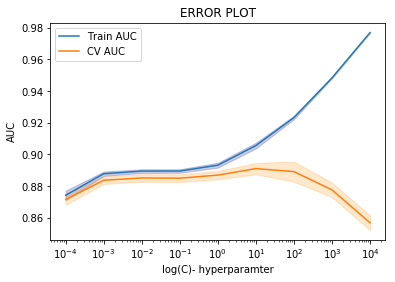

+---------------+--------------+---------------+
| Mean CV Score | Std CV Score |     Param     |
+---------------+--------------+---------------+
|     0.871     |   0.00665    | {'C': 0.0001} |
|     0.884     |   0.00481    |  {'C': 0.001} |
|     0.885     |   0.00469    |  {'C': 0.01}  |
|     0.885     |   0.00487    |   {'C': 0.1}  |
|     0.887     |   0.00526    |    {'C': 1}   |
|     0.891     |   0.00718    |   {'C': 10}   |
|     0.889     |   0.01278    |   {'C': 100}  |
|     0.878     |   0.00915    |  {'C': 1000}  |
|     0.857     |    0.0093    |  {'C': 10000} |
+---------------+--------------+---------------+

The best estimator:SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

The best score is:0.8909829967726378
The best value of C is:{'C': 10}
Mean Score: 0.9008120500946798


In [52]:
# Hyper parameter tuning and error plot
tuned_parameters = [{'C': [10**-4, 10**-3,10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]}]
alpha = [10**-4, 10**-3,10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]  #k
    
    
# Using GridSearchCVSearchCV with 3 fold cv
gs_obj = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, scoring = 'roc_auc', cv=3)
gs_obj.fit(sent_vectors_train, y_train)


train_auc= gs_obj.cv_results_['mean_train_score']
train_auc_std= gs_obj.cv_results_['std_train_score']
cv_auc = gs_obj.cv_results_['mean_test_score'] 
cv_auc_std= gs_obj.cv_results_['std_test_score']

  
# draws the error plot
  
plt.plot(alpha, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039 
plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C)- hyperparamter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("ERROR PLOT")
plt.show()
  
  
 # Results of the gs object
  
  
# Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
means = gs_obj.cv_results_['mean_test_score']
stds = gs_obj.cv_results_['std_test_score']


t1 = PrettyTable()
t1.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
    t1.add_row([round(mean, 3), round(std * 2,5), params])

print(t1) 

print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
print("\nThe best score is:{}".format(gs_obj.best_score_))
print("The best value of C is:{}".format(gs_obj.best_params_))

# Returns the mean accuracy on the given test data and labels.
print("Mean Score: {}".format(gs_obj.score(sent_vectors_test, y_test)))

del t1

In [48]:
# Fitting the model with the best hyperparameter 
model_avgw2v_rbf = SVC(kernel='rbf', C= 10,probability=True)
model_avgw2v_rbf.fit(sent_vectors_train,y_train)
y_pred = model_avgw2v_rbf.predict(sent_vectors_test)

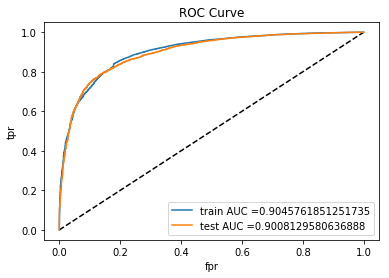

train AUC: 0.9045761851251735
test AUC: 0.9008129580636888


In [49]:
# AUC - ROC plot
auc_train_avgw2v_rbf, auc_test_avgw2v_rbf = plot_auc_rbf(model_avgw2v_rbf, sent_vectors_train, sent_vectors_test)

In [50]:
# Confusion matrix
print_confusion_matrix(model_avgw2v_rbf, sent_vectors_train, sent_vectors_test)

*****Train confusion matrix*****
[[ 1508  2545]
 [  462 21675]]

*****Test confusion matrix*****
[[ 794 1244]
 [ 215 8972]]


<Figure size 432x288 with 0 Axes>

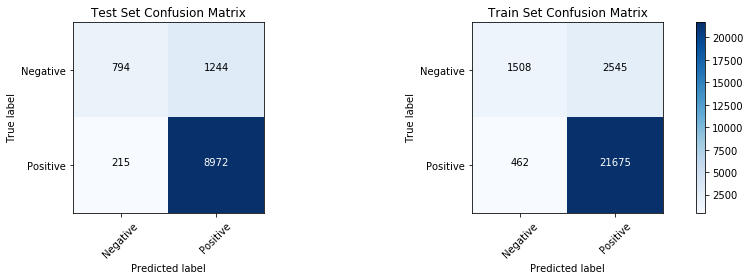

In [51]:
# Heatmap confusion matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_avgw2v_rbf.predict(sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_avgw2v_rbf.predict(sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the Avg. W2V vectorizer, we used SVC classifier with RBF kernel and C = 10
2. We got train AUC: 0.9045761851251735 and test AUC: 0.9008129580636888
3. Using the confusion matrix, we can say that our model correctly predicted 8972 positive reviews and 794 negative reviews.
4. The model incorrectly classified 215 negative reviews and 1244 positive reviews.

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

**TFIDF-Weighted Word2Vec**

In [23]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
X_train_tf_idf_w2v = model.fit_transform(X_train)
X_test_tf_idf_w2v = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [24]:
# TF-IDF weighted Word2Vec for sentences in X_train
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26190/26190 [05:59<00:00, 72.91it/s]


In [25]:
# TF-IDF weighted Word2Vec for sentences in X_test
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11225/11225 [02:33<00:00, 72.96it/s]


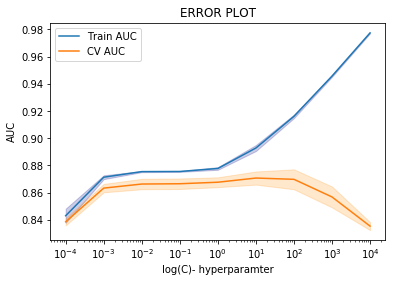

+---------------+--------------+---------------+
| Mean CV Score | Std CV Score |     Param     |
+---------------+--------------+---------------+
|     0.839     |   0.00531    | {'C': 0.0001} |
|     0.863     |    0.0062    |  {'C': 0.001} |
|     0.866     |   0.00765    |  {'C': 0.01}  |
|     0.867     |   0.00773    |   {'C': 0.1}  |
|     0.868     |   0.00725    |    {'C': 1}   |
|     0.871     |    0.0097    |   {'C': 10}   |
|      0.87     |   0.01467    |   {'C': 100}  |
|     0.857     |   0.01535    |  {'C': 1000}  |
|     0.835     |    0.0059    |  {'C': 10000} |
+---------------+--------------+---------------+

The best estimator:SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

The best score is:0.870704860021974
The best value of C is:{'C': 10}
Mean Score: 0.881100630418906


{'C': 10}

In [26]:
get_best_hyperparameter_alpha_rbf(model, tfidf_sent_vectors_train, tfidf_sent_vectors_test, y_train, y_test)

In [35]:
# Fitting the TFIDF - weighted W2V vectorizer on LogisticRegression Model 
model_tfidfw2v_rbf = SVC(kernel='rbf', C= 10, probability=True)
model_tfidfw2v_rbf.fit(tfidf_sent_vectors_train,y_train)
y_pred = model_tfidfw2v_rbf.predict(tfidf_sent_vectors_test)

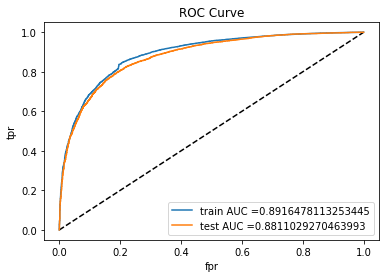

train AUC: 0.8916478113253445
test AUC: 0.8811029270463993


In [36]:
# AUC- ROC plot
auc_train_tfidfw2v_rbf, auc_test_tfidfw2v_rbf = plot_auc_rbf(model_tfidfw2v_rbf, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

In [37]:
# Confusion Matrix
print_confusion_matrix(model_tfidfw2v_rbf, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

*****Train confusion matrix*****
[[ 1147  2906]
 [  323 21814]]

*****Test confusion matrix*****
[[ 609 1429]
 [ 157 9030]]


<Figure size 432x288 with 0 Axes>

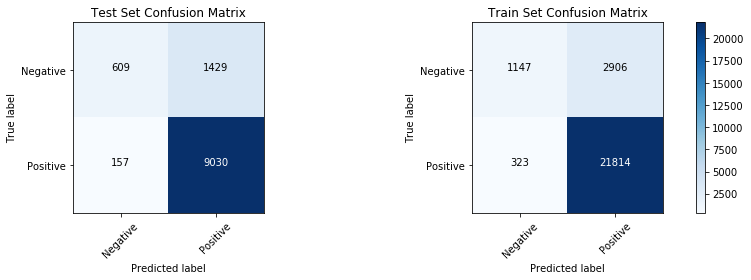

In [41]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidfw2v_rbf.predict(tfidf_sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidfw2v_rbf.predict(tfidf_sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the TFIIDF-weightedW2V vectorizer, we used SVC classifier with RBF kernel and alpha = 10
2. We got train AUC: 0.8916478113253445 and test AUC: 0.8811029270463993
3. Using the confusion matrix, we can say that our model correctly predicted 9030 positive reviews and 609 negative reviews.
4. The model incorrectly classified 157 negative reviews and 1429 positive reviews.


# [6] Conclusions

In [120]:
C = PrettyTable()

C.field_names = ['Sr. No', 'Vectorizer','Hyperparameter value','Penalty', 'Train AUC', 'Test AUC']
C.add_row([1, 'BoW', 'L2', 0.1, auc_train_bow_sgd, auc_train_bow_sgd])
C.add_row([2, 'BoW', 'L2', 1,auc_train_bow_rbf ,auc_test_bow_rbf])
C.add_row([3, 'TF_IDF', 'L2', 0.0001, auc_train_tfidf_sgd, auc_test_tfidf_sgd])
C.add_row([4, 'TF_IDF', 'L2', 10000, auc_train_tfidf_rbf, auc_train_tfidf_rbf])
C.add_row([5, 'Avg-W2V', 'L2', 0.01,auc_train_avgw2v_l1, auc_test_avgw2v_l1])
C.add_row([6, 'Avg-W2V', 'L2', 10,auc_train_avgw2v_rbf ,auc_test_avgw2v_rbf])
C.add_row([7, 'TFIDF-W2V', 'L2', 0.01,auc_train_tfidfw2v_sgd, auc_test_tfidfw2v_sgd])
C.add_row([8, 'TFIDF-W2V', 'L2', 10, auc_train_tfidfw2v_rbf,auc_test_tfidfw2v_rbf])
           

print(C)
del C

+--------+------------+----------------------+---------+--------------------+--------------------+
| Sr. No | Vectorizer | Hyperparameter value | Penalty |     Train AUC      |      Test AUC      |
+--------+------------+----------------------+---------+--------------------+--------------------+
|   1    |    BoW     |          L2          |   0.1   | 0.9844621305883833 | 0.9844621305883833 |
|   2    |    BoW     |          L2          |    1    | 0.9665197249066753 | 0.9036183953666663 |
|   3    |   TF_IDF   |          L2          |  0.0001 | 0.9748968093818116 | 0.9603306201559176 |
|   4    |   TF_IDF   |          L2          |  10000  | 0.9922475342828719 | 0.9922475342828719 |
|   5    |  Avg-W2V   |          L2          |   0.01  | 0.9020367007582843 | 0.9026262821709552 |
|   6    |  Avg-W2V   |          L2          |    10   | 0.9045761851251735 | 0.9008129580636888 |
|   7    | TFIDF-W2V  |          L2          |   0.01  | 0.8784768314946081 | 0.8740695670883443 |
|   8    |

## Summary

1. We performed Support Vector Machine Classification on the Amazon fine food dataset using SGDClasssifier for the linear kernel and SVC for RBF kernel 
2. Made use of GridSearchCV to find the best value of C , the hyperparameter. We also used CalibratedSearchCV when working with SGD classifier. 
3. Performed Feature Engineering on the BoW model and found out the model slightly performed better.
4. Different vectors take on different hyperparameter values. We saw values being taken from  10**-4 to 10**4
5. We also found penalty L1 and L2 using hyperparameter tuning on BoW, TFIDF, Avg-W2V, TFIDF-WW2V on the Amazon Fine Food Reviews.
6. We also printed out feature importance for BoW vectorizer